In [282]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
import branca

In [2]:
spark = (
    SparkSession.builder.appName("preprocessing of taxi data")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "15g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/23 18:35:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/08/23 18:35:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/08/23 18:35:12 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/08/23 18:35:12 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/08/23 18:35:12 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/08/23 18:35:12 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
22/08/23 18:35:12 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
22/08/23 18:35:12 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.
22/08/23 18:35:12 WARN Utils: Service 'SparkUI' could not bind on port 4047. Attempting port 4048.


In [149]:
modelling_sdf = spark.read.parquet('../data/curated/aggregated')

In [216]:
train_sdf = modelling_sdf.filter(F.col("date") <= "2016-12-31")
valid_sdf = modelling_sdf.filter((F.col("date") > "2016-12-31") & (F.col("date") <= "2017-02-28"))
test_sdf = modelling_sdf.filter((F.col("date") > "2017-02-28") & (F.col("date") <= "2017-05-31"))
print(train_sdf.count())
print(valid_sdf.count())
print(test_sdf.count())

927997
141709
221574


In [223]:
train = train_sdf.toPandas()
valid = valid_sdf.toPandas()
test = test_sdf.toPandas()
xname =  ['PULocationID',
          'average_temperature',
          'precip',
          'date',
          'time_float',
          'cos_time',
          'sin_time',
          'date_float',
          'cos_date',
          'sin_date',
          'month_float',
          'cos_month',
          'sin_month',
          'holiday']
xtrain = train[xname]
xvalid = valid[xname]
xtest = test[xname]

ytrain = np.log10(train['high_value_trips'] + 1)
yvalid = np.log10(valid['high_value_trips'] + 1)
ytest = np.log10(test['high_value_trips'] + 1)

In [224]:
ohe = OneHotEncoder(handle_unknown='ignore')

Train_data_to_ohe = xtrain[['PULocationID']]
Train_data_ohe = ohe.fit_transform(Train_data_to_ohe).toarray()

Train_data_ohe = pd.DataFrame(Train_data_ohe, columns=list(ohe.get_feature_names_out(['PULocationID'])))

xtrain = xtrain.drop(['PULocationID'], axis=1)

for col in Train_data_ohe.columns:
    new_col = Train_data_ohe[col]
    new_col.index = range(len(new_col))

    xtrain[str(col)] = new_col


Val_data_to_ohe = xvalid[['PULocationID']]
Val_data_ohe = ohe.transform(Val_data_to_ohe).toarray()

Val_data_ohe = pd.DataFrame(Val_data_ohe, columns=list(ohe.get_feature_names_out(['PULocationID'])))

xvalid = xvalid.drop(['PULocationID'], axis=1)

for col in Val_data_ohe.columns:
    new_col = Val_data_ohe[col]
    new_col.index = range(len(new_col))

    xvalid[str(col)] = new_col


Test_data_to_ohe = xtest[['PULocationID']]
Test_data_ohe = ohe.transform(Test_data_to_ohe).toarray()

Test_data_ohe = pd.DataFrame(Test_data_ohe, columns=list(ohe.get_feature_names_out(['PULocationID'])))

xtest = xtest.drop(['PULocationID'], axis=1)

for col in Test_data_ohe.columns:
    new_col = Test_data_ohe[col]
    new_col.index = range(len(new_col))

    xtest[str(col)] = new_col

/var/folders/mk/5m0_ggk577s5d_q78b0zrg540000gn/T/ipykernel_59255/273907451.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  xtrain[str(col)] = new_col
/var/folders/mk/5m0_ggk577s5d_q78b0zrg540000gn/T/ipykernel_59255/273907451.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  xvalid[str(col)] = new_col
/var/folders/mk/5m0_ggk577s5d_q78b0zrg540000gn/T/ipykernel_59255/273907451.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

In [225]:
visualise_test = xtest.copy(deep=True)

In [226]:
xtrain = xtrain.drop(['date'], axis=1)
xvalid = xvalid.drop(['date'], axis=1)
xtest = xtest.drop(['date'], axis=1)

In [10]:
from sklearn.metrics import mean_squared_error


reg = RandomForestRegressor()
print("fitting")
reg.fit(xtrain,ytrain)
print("training")
training_accuracy = reg.score(xtrain, ytrain)
valid_accuracy = reg.score(xvalid, yvalid)
testing_accuracy = reg.score(xtest, ytest)
rmsetrain = np.sqrt(mean_squared_error(reg.predict(xtrain),ytrain))
rmsevalid = np.sqrt(mean_squared_error(reg.predict(xvalid),yvalid))
rmsetest = np.sqrt(mean_squared_error(reg.predict(xtest),ytest))
print("R^2 (train) = %0.3f, R^2 (valid) = %0.3f, R^2 (test) = %0.3f, RMSE (train) = %0.3f, RMSE (valid) = %0.3f, RMSE (test) = %0.3f" % 
        (training_accuracy, valid_accuracy, testing_accuracy, rmsetrain, rmsevalid, rmsetest))

fitting
training
R^2 (train) = 0.990, R^2 (valid) = 0.904, R^2 (test) = 0.887, RMSE (train) = 0.067, RMSE (valid) = 0.209, RMSE (test) = 0.223


Due to the time taken to train the model being too long, i have decide to reduce the number of estimators and apply limits to dataset size, feature size, tree depth and number of trees.

In [24]:
# Number of trees in random forest
n_estimators = list(range(10, 100, 10))
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = list(range(10, 110, 10))
max_depth.append(None)

bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = reg, param_distributions = random_grid, n_iter = 50, cv = 2, n_jobs = -1)
rf_random.fit(xtrain, ytrain)
rf_random.best_params_

/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 70,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [ ]:
rf_reg = RandomForestRegressor(n_estimators=70, max_features='auto', max_depth=100, bootstrap='True')
rf_reg.fit(xtrain, ytrain)
train_accuracy = rf_reg.score(xtrain, ytrain)
rmsetrain = np.sqrt(mean_squared_error(rf_reg.predict(xtrain),ytrain))

In [41]:
print(train_accuracy, rmsetrain)

0.9796782464859776 0.09646724749681594


In [33]:
rf_reg.fit(xvalid, yvalid)
valid_accuracy = rf_reg.score(xvalid, yvalid)
rmsevalid = np.sqrt(mean_squared_error(rf_reg.predict(xvalid),yvalid))
print(valid_accuracy, rmsevalid)

0.9834266722167857 0.08655891884218696


In [34]:
rf_reg.fit(xtest, ytest)
test_accuracy = rf_reg.score(xtest, ytest)
rmsetest = np.sqrt(mean_squared_error(rf_reg.predict(xtest),ytest))
print(test_accuracy, rmsetest)

0.9822148187219975 0.08857673766800314


In [19]:
import xgboost
xtrain["precip"] = pd.to_numeric(xtrain['precip'], errors='coerce')
r = xgboost.XGBRegressor()
print("training")
r.fit(xtrain, ytrain)
print("testing")
training_accuracy = r.score(xtrain, ytrain)
print(training_accuracy)

training
testing
0.8799348469849552


In [23]:
# Number of trees in random forest
n_estimators = list(range(10, 100, 10))
# Maximum number of levels in tree
max_depth = list(range(10, 110, 10))
learning_rate = [0.05, 0.1, 0.20]
booster = ['gbtree', 'gblinear', 'dart']

bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'booster': booster}
xgb_random = RandomizedSearchCV(estimator = r, param_distributions = random_grid, n_iter = 50, cv = 2, n_jobs = -1)
xgb_random.fit(xtrain, ytrain)
xgb_random.best_params_

[09:40:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_constraints", "max_bin", "max_cat_to_onehot", "max_delta_step", "max_depth", "max_leaves", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "sampling_method", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[09:40:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "grow_policy", "interaction_const

{'n_estimators': 80,
 'max_depth': 80,
 'learning_rate': 0.05,
 'booster': 'gbtree'}

In [42]:
xgb_reg = xgboost.XGBRegressor(n_estimators=80, max_depth = 80, learning_rate=0.05, booster='gbtree')
xtrain["precip"] = pd.to_numeric(xtrain['precip'], errors='coerce')
xgb_reg.fit(xtrain,ytrain)
train_accuracy = xgb_reg.score(xtrain, ytrain)
rmsetrain = np.sqrt(mean_squared_error(xgb_reg.predict(xtrain),ytrain))
print(train_accuracy, rmsetrain)

0.9771898594984134 0.10220291373955726


In [32]:
xvalid["precip"] = pd.to_numeric(xvalid['precip'], errors='coerce')
xgb_reg.fit(xvalid,yvalid)
valid_accuracy = xgb_reg.score(xvalid, yvalid)
rmsevalid = np.sqrt(mean_squared_error(xgb_reg.predict(xvalid),yvalid))
print(valid_accuracy, rmsevalid)

0.9826724869777884 0.08850648236342418


In [35]:
xgb_reg.fit(xtest, ytest)
xtest["precip"] = pd.to_numeric(xtest['precip'], errors='coerce')
test_accuracy = xgb_reg.score(xtest, ytest)
rmsetest = np.sqrt(mean_squared_error(xgb_reg.predict(xtest),ytest))
print(test_accuracy, rmsetest)

0.9823627281924397 0.08820764693023686


In [ ]:
#145

In [227]:
visualise_test["date"] = pd.to_datetime(visualise_test["date"])

In [228]:
visualise_test = visualise_test.loc[(visualise_test["PULocationID_145"] == 1) & (visualise_test["date"] == "2017-04-20")]
visualise_test = visualise_test.drop(['date'], axis=1)
visualise_test["precip"] = pd.to_numeric(visualise_test['precip'], errors='coerce')
rf_pred_vis = rf_reg.predict(visualise_test)
xgb_pred_vis = xgb_reg.predict(visualise_test)

In [296]:
y_vis = ytest.iloc[visualise_test.index]

In [297]:
HOURS = [f'{str(hr).zfill(2)}:00' for hr in range(24)]
result = pd.DataFrame(np.round(np.power(10,np.column_stack((rf_pred_vis, xgb_pred_vis))) - 1,decimals=0).astype(int), index=HOURS)

In [298]:
y_vis = pd.DataFrame(list(y_vis))
y_vis

,0
0,0.602060
1,0.778151
2,0.301030
3,0.477121
4,0.602060
5,1.000000
6,0.778151
7,0.602060
8,0.477121
9,0.698970


In [299]:
result.insert(2, '2', y_vis, True)
result

,0,1,2
00:00,8,6,0.602060
01:00,8,8,0.778151
02:00,2,2,0.301030
03:00,1,2,0.477121
04:00,5,4,0.602060
05:00,9,7,1.000000
06:00,4,4,0.778151
07:00,4,3,0.602060
08:00,2,4,0.477121
09:00,4,5,0.698970


In [300]:
result['2'] = np.round(np.power(10, result['2']) - 1,decimals=0).astype(int)
result.columns = ['Random Forest Prediction', 'XGboost prediction', 'Actual amount of high value trips']

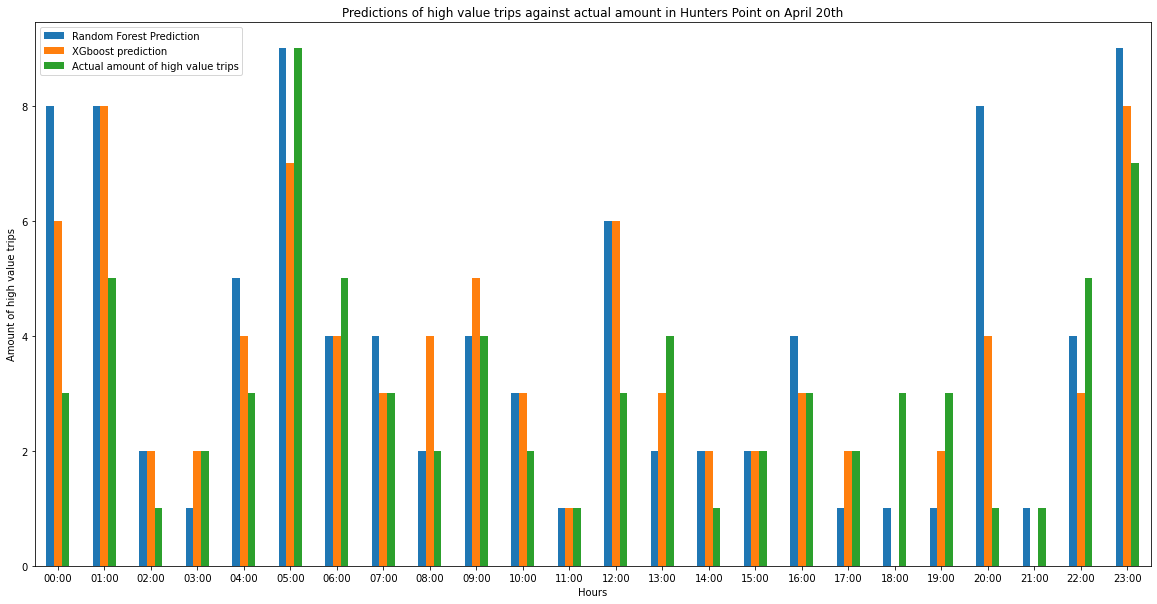

In [310]:
text = "Predictions of high value trips against actual amount in Hunters Point on April 20th"
ax = result.plot.bar(rot=0, 
                    figsize=(20,10), 
                    xlabel="Hours", 
                    ylabel="Amount of high value trips",
                    title=text).get_figure()
ax.savefig("../plots/predictions.png")